In [1]:
!pip install seaborn matplotlib

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Create SparkSession
spark = SparkSession.builder \
    .appName("SimpleApp") \
    .getOrCreate()



your 131072x1 screen size is bogus. expect trouble
25/04/16 10:11:44 WARN Utils: Your hostname, VITUS resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/04/16 10:11:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/16 10:11:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:

# Read CSV File
df_fare = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_fare_1.csv")
df_trip = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_data_1.csv")


In [6]:
def clean_column_names(df):
    return df.select([F.col(col_name).alias(col_name.strip()) for col_name in df.columns])

# Очистити назви стовпців у обох DataFrame
df_fare = clean_column_names(df_fare)
df_trip = clean_column_names(df_trip)

In [7]:
df_trip = df_trip.filter(
    (F.col("passenger_count") > 0) & (F.col("passenger_count") <= 10) &
    (F.col("trip_time_in_secs") > 0) &
    (F.col("trip_distance") > 0) &
    (F.col("pickup_latitude").between(40.5, 41.0)) &
    (F.col("dropoff_latitude").between(40.5, 41.0)) &
    (F.col("pickup_longitude").between(-74.5, -73.0)) &
    (F.col("dropoff_longitude").between(-74.5, -73.0)) &
    (F.col("pickup_datetime") <= F.lit("2013-01-28"))
)

df_fare = df_fare.filter(
    (F.col("fare_amount") >= 0) &
    (F.col("tip_amount") >= 0) &
    (F.col("tolls_amount") >= 0) &
    (F.col("total_amount") >= 0) &
    ((F.col("fare_amount") > 0) | (F.col("payment_type") == "NOC")) &
    (F.col("pickup_datetime") <= F.lit("2013-01-28"))
)

In [8]:
df_fare.show()

+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|        hack_license|vendor_id|    pickup_datetime|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|2013-01-01 15:11:48|         CSH|        6.5|      0.0|    0.5|       0.0|         0.0|         7.0|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|2013-01-06 00:18:35|         CSH|        6.0|      0.5|    0.5|       0.0|         0.0|         7.0|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|2013-01-05 18:49:41|         CSH|        5.5|      1.0|    0.5|       0.0|         0.0|         7.0|
|DFD2202EE08F7A8DC...|51EE87E3205C985EF...|      CMT|2013-01-07 23:54:15|   

In [9]:
df_trip.show()

+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N|2013-01-01 15:11:48|2013-01-01 15:18:10|              4|              382|          1.0|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...| 

# MAP (Filter, Window, group by)

In [13]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import folium
from branca.colormap import LinearColormap
from datetime import datetime, timedelta

# 1. Фільтрація даних за останні 7 днів
max_date = df_trip.agg(F.max(F.to_date("dropoff_datetime"))).collect()[0][0]
df_last_week = df_trip.filter(
    (F.to_date("dropoff_datetime") >= F.date_sub(F.lit(max_date), 7)) & 
    (F.to_date("dropoff_datetime") <= F.lit(max_date))
)

# 2. Розрахунок сітки та віконних функцій
grid_size = 0.02


grid_data = df_last_week.withColumn(
    "lat_grid", (F.round(F.col("dropoff_latitude") / grid_size) * grid_size)
).withColumn(
    "lon_grid", (F.round(F.col("dropoff_longitude") / grid_size) * grid_size)
).filter(
    F.col("lat_grid").isNotNull() & 
    F.col("lon_grid").isNotNull()
).groupBy("lat_grid", "lon_grid").agg(
    F.count("*").alias("total_trips")
).withColumn(
    "rank", F.row_number().over(
        Window.orderBy(F.desc("total_trips"))
    )
).withColumn(
    "moving_avg", F.avg("total_trips").over(
        Window.orderBy("total_trips").rowsBetween(-2, 2)
    )
).orderBy(F.desc("total_trips"))

m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Додаємо прямокутники на мапу
max_total = max([x.total_trips for x in grid_data.collect()])
colormap = LinearColormap(
    ['#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026'],
    vmin=0,
    vmax=max_total
)

for point in grid_data.collect():
    bounds = [
        [point.lat_grid, point.lon_grid],
        [point.lat_grid + grid_size, point.lon_grid + grid_size]
    ]

    popup_text = f"""
    <b>Rank:</b> {point.rank}<br>
    <b>Total Trips:</b> {point.total_trips}<br>
    <b>3-Point Moving Avg:</b> {point.moving_avg:.1f}
    """

    folium.Rectangle(
        bounds=bounds,
        color=colormap(point.total_trips),
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=300),
        weight=0
    ).add_to(m)

colormap.add_to(m)
colormap.caption = 'Загальна кількість поїздок за тиждень'

m.save('../results/ranked_map_without_grouping_by_day.html')
print("Інтерактивна мапа збережена як ranked_map_without_grouping_by_day.html")


25/04/16 10:18:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:18:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:18:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:18:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:18:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:18:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 1

Інтерактивна мапа збережена як ranked_map_without_grouping_by_day.html


In [15]:
grid_data.write.csv('../results/map_info.csv')

25/04/16 10:19:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:19:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:19:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:19:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:20:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:20:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 1

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/mnt/d/REPOSITORY/github/nyc-taxi-spark-project/results/map_info.csv already exists. Set mode as "overwrite" to overwrite the existing path.

# Час Простою (Filter, Window, Group By)

In [16]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Визначити дату останнього тижня (приклад: останні 7 днів)
current_date = df_trip.agg(F.max(F.to_date("pickup_datetime"))).collect()[0][0]
start_date = F.date_sub(F.lit(current_date), 7)

# Фільтрація даних за останній тиждень
last_week_data = df_trip.filter(
    (F.col("pickup_datetime") >= start_date) &
    (F.col("pickup_datetime") < F.lit(current_date))
)

# Визначення часу наступної поїздки для кожного водія
window = Window.partitionBy("hack_license").orderBy("pickup_datetime")

# Розрахунок простою
downtime_df = last_week_data.withColumn(
    "next_pickup", 
    F.lead("pickup_datetime").over(window)
).withColumn(
    "downtime_sec", 
    F.unix_timestamp("next_pickup") - F.unix_timestamp("dropoff_datetime")
).filter(
    F.col("downtime_sec") > 0  # Ігноруємо негативні значення (помилки даних)
)

# Групування по днях тижня та розрахунок середнього
result = downtime_df.withColumn(
    "day_of_week", 
    F.date_format("pickup_datetime", "EEEE")  # Поверне назву дня (наприклад, "Monday")
).groupBy("day_of_week").agg(
    F.avg("downtime_sec").alias("avg_downtime_sec"),
    F.count("*").alias("total_downtime_events")
).orderBy("day_of_week")

result.show()
result.write.csv('../results/waiting_time.csv')

+-----------+------------------+---------------------+
|day_of_week|  avg_downtime_sec|total_downtime_events|
+-----------+------------------+---------------------+
|     Friday|3283.8312625864805|               515434|
|     Monday| 5454.486067879041|               372987|
|   Saturday|2412.8972019533107|               533658|
|     Sunday|1382.3182003835157|               433359|
|   Thursday| 3211.657456169459|               512314|
|    Tuesday| 3703.222536020894|               480138|
|  Wednesday|3817.2026845290434|               502658|
+-----------+------------------+---------------------+



/tmp/ipykernel_224394/3847546857.py:37: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


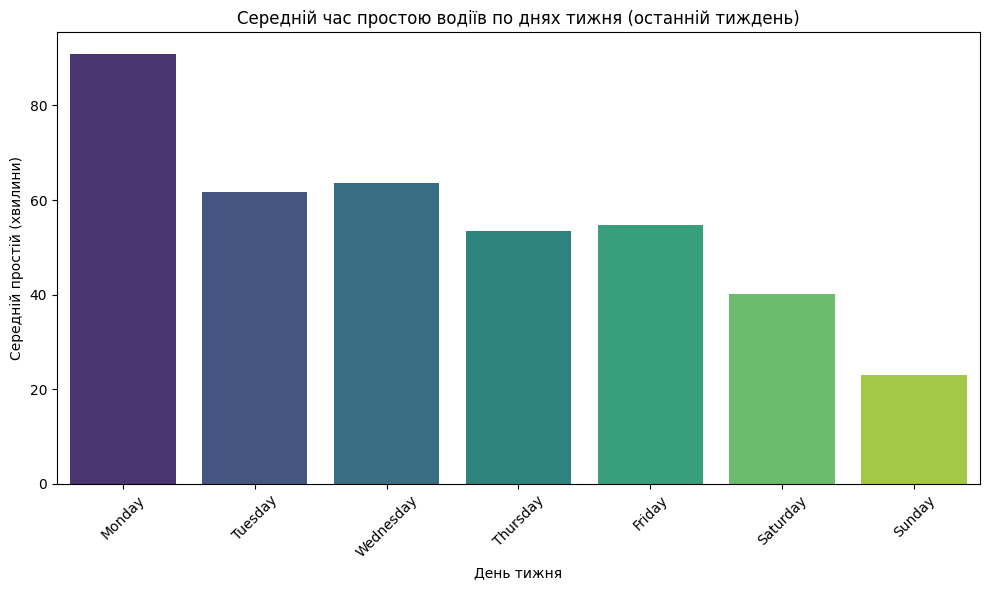

In [17]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Розрахунок середнього часу простою (в секундах)
current_date = df_trip.agg(F.max(F.to_date("pickup_datetime"))).collect()[0][0]
start_date = F.date_sub(F.lit(current_date), 7)

last_week_data = df_trip.filter(
    (F.col("pickup_datetime") >= start_date) &
    (F.col("pickup_datetime") < F.lit(current_date))
)
window = Window.partitionBy("hack_license").orderBy("pickup_datetime")

downtime_df = last_week_data.withColumn(
    "next_pickup", 
    F.lead("pickup_datetime").over(window)
).withColumn(
    "downtime_sec", 
    F.unix_timestamp("next_pickup") - F.unix_timestamp("dropoff_datetime")
).filter(F.col("downtime_sec") > 0)

result = downtime_df.withColumn(
    "day_of_week", 
    F.date_format("pickup_datetime", "EEEE")
).groupBy("day_of_week").agg(
    (F.avg("downtime_sec") / 60).alias("avg_downtime_min"),  # Конвертація в хвилини
    F.count("*").alias("total_downtime_events")
).orderBy("day_of_week")

# 2. Конвертація в Pandas DataFrame для візуалізації
pd_result = result.toPandas()

# 3. Візуалізація з Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    x="day_of_week", 
    y="avg_downtime_min", 
    data=pd_result,
    order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],  # Сортування днів
    palette="viridis"
)

plt.title("Середній час простою водіїв по днях тижня (останній тиждень)")
plt.xlabel("День тижня")
plt.ylabel("Середній простій (хвилини)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_224394/1381059697.py:45: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


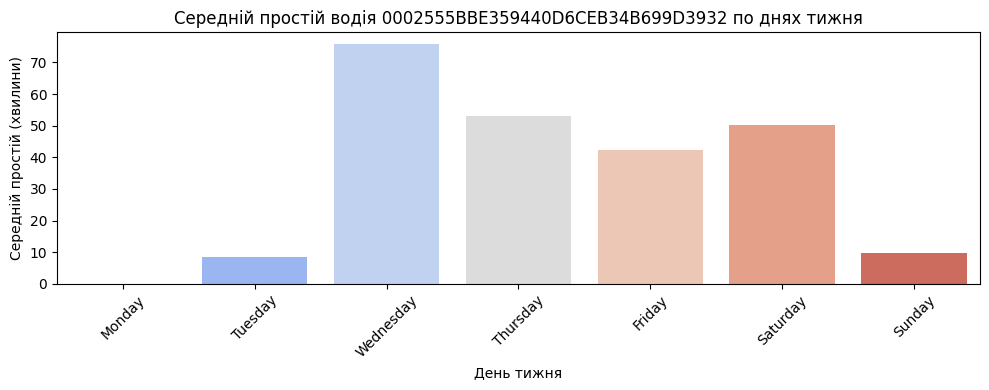

/tmp/ipykernel_224394/1381059697.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


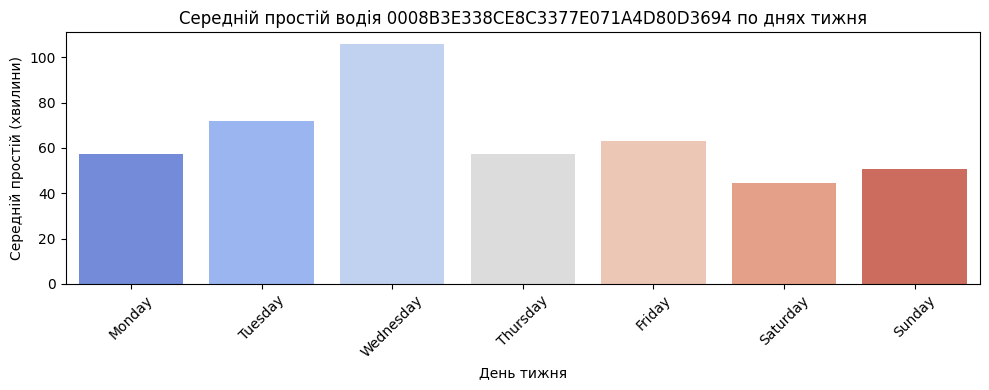

/tmp/ipykernel_224394/1381059697.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


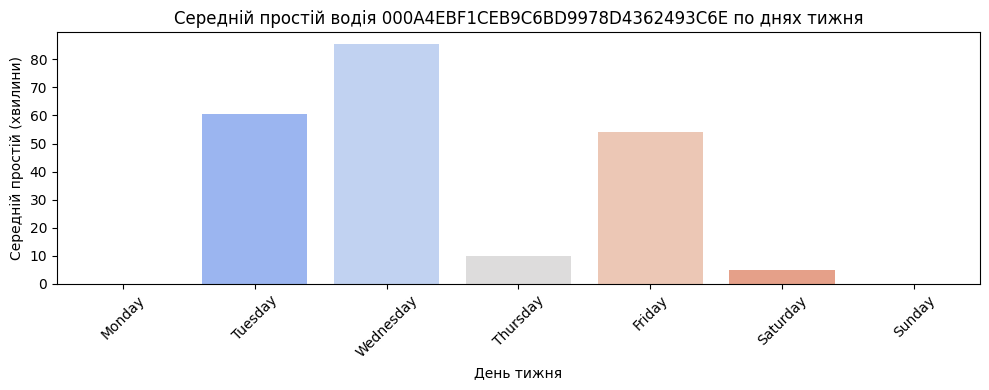

/tmp/ipykernel_224394/1381059697.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


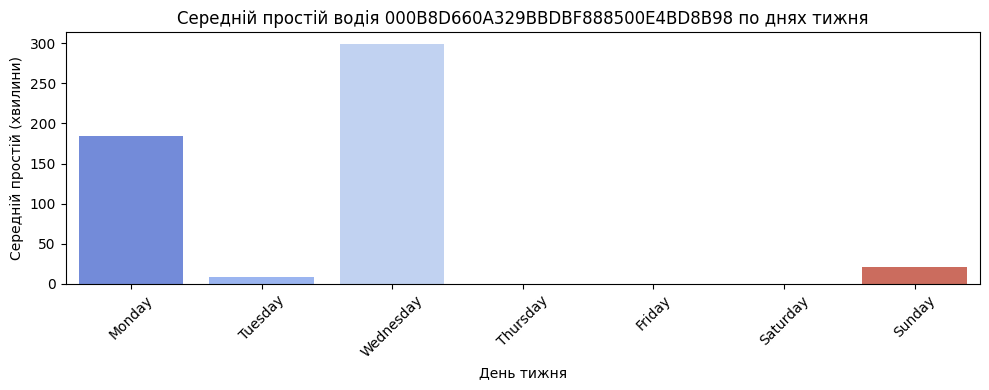

/tmp/ipykernel_224394/1381059697.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


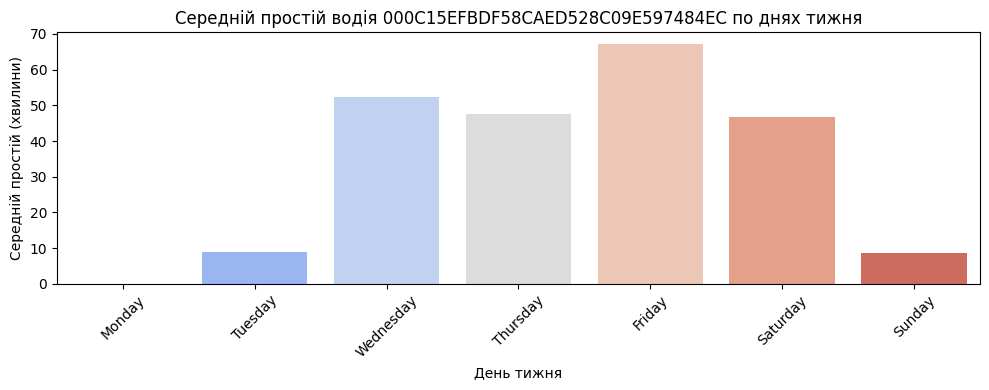

In [18]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Фільтрація даних за останній тиждень
current_date = df_trip.agg(F.max(F.to_date("pickup_datetime"))).collect()[0][0]
start_date = F.date_sub(F.lit(current_date), 7)

last_week_data = df_trip.filter(
    (F.col("pickup_datetime") >= start_date) &
    (F.col("pickup_datetime") < F.lit(current_date))
)

# 2. Розрахунок часу простою для кожного водія
window = Window.partitionBy("hack_license").orderBy("pickup_datetime")

downtime_per_driver = last_week_data.withColumn(
    "next_pickup", 
    F.lead("pickup_datetime").over(window)
).withColumn(
    "downtime_min", 
    (F.unix_timestamp("next_pickup") - F.unix_timestamp("dropoff_datetime")) / 60
).filter(F.col("downtime_min") > 0)

# 3. Групування по водію та дню тижня
result = downtime_per_driver.withColumn(
    "day_of_week", 
    F.date_format("pickup_datetime", "EEEE")
).groupBy("hack_license", "day_of_week").agg(
    F.avg("downtime_min").alias("avg_downtime"),
    F.count("*").alias("total_rides")
).orderBy("hack_license", "day_of_week")

# 4. Конвертація в Pandas для візуалізації
pd_result = result.toPandas()

# 5. Візуалізація для перших 5 водіїв (як приклад)
sample_drivers = pd_result["hack_license"].unique()[:5]

for driver in sample_drivers:
    driver_data = pd_result[pd_result["hack_license"] == driver]
    
    plt.figure(figsize=(10, 4))
    sns.barplot(
        x="day_of_week", 
        y="avg_downtime", 
        data=driver_data,
        order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
        palette="coolwarm"
    )
    
    plt.title(f"Середній простій водія {driver} по днях тижня")
    plt.xlabel("День тижня")
    plt.ylabel("Середній простій (хвилини)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# NO CHARGE (Filter, Group By)

In [19]:
from pyspark.sql import functions as F

# JOIN по спільним ключам
joined_df = df_trip.join(
    df_fare,
    ["medallion", "hack_license", "pickup_datetime", "vendor_id"],
    "inner"
)

# Додаємо стовпець з тижневою датою (понеділок кожного тижня)
joined_df = joined_df.withColumn(
    "week_start",
    F.date_trunc("week", F.col("pickup_datetime"))
)

# Фільтруємо тільки поїздки з нульовою або більшою відстанню
filtered_df = joined_df.filter(F.col("vendor_id") == "CMT" )

# Групування по тижнях
weekly_stats = filtered_df.groupBy("week_start").agg(
    F.sum(
        F.when(F.col("payment_type") == "NOC", F.col("trip_distance"))
    ).alias("total_noc_distance"),
    F.sum(
        F.when(F.col("payment_type") == "NOC", F.col("total_amount"))
    ).alias("lost_revenue_noc")
).orderBy("week_start")
 

In [20]:
weekly_stats

DataFrame[week_start: timestamp, total_noc_distance: double, lost_revenue_noc: double]

25/04/16 10:23:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:23:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:23:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:23:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:23:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:23:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:23:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:23:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:23:26 WARN RowBasedKeyValueBatch: Calling spill() on

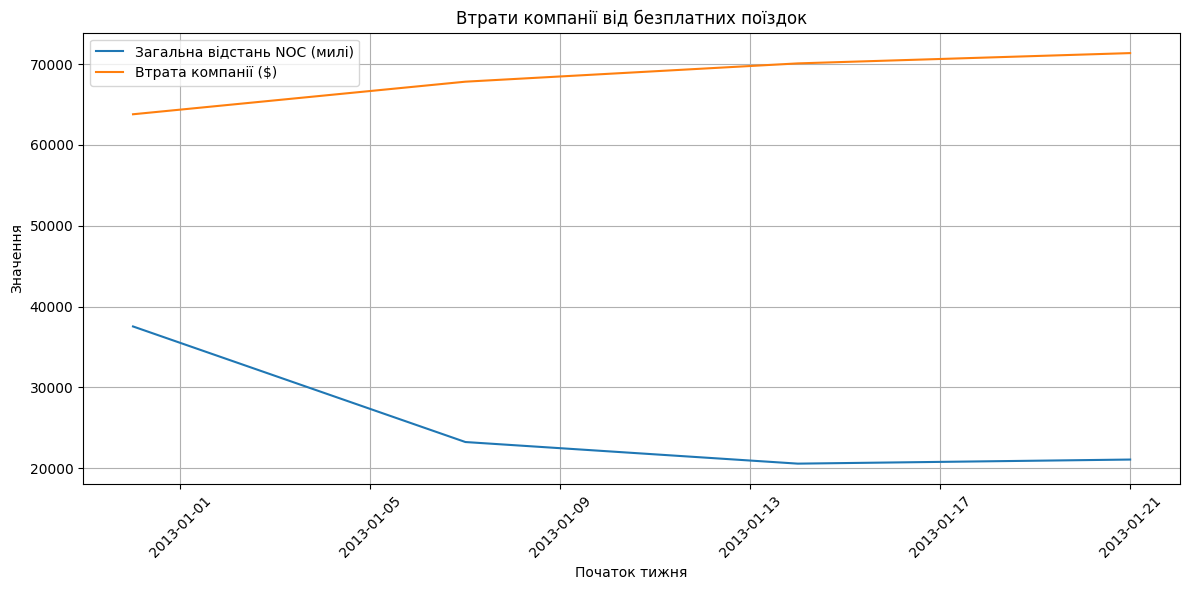

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


pdf = weekly_stats.toPandas()[:-1]

# Побудова графіка
plt.figure(figsize=(12, 6))
sns.lineplot(data=pdf, x="week_start", y="total_noc_distance", label="Загальна відстань NOC (милі)")
sns.lineplot(data=pdf, x="week_start", y="lost_revenue_noc", label="Втрата компанії ($)")

plt.title("Втрати компанії від безплатних поїздок")
plt.xlabel("Початок тижня")
plt.ylabel("Значення")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [22]:
pdf.to_csv('../results/Noc-loss.csv')

# середній заробіток і кількість поїздок в залежності від часу доби (Join, Group By)

In [23]:

# Виконання JOIN
joined_df = df_trip.join(
    df_fare,
    ["medallion", "hack_license","pickup_datetime","vendor_id"],
    "inner"
)



In [24]:
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Витягнути годину з часу початку поїздки
analysis_df = joined_df.withColumn("pickup_hour", F.hour("pickup_datetime"))

# 2. Групування за годиною та агрегація
result = analysis_df.groupBy("pickup_hour") \
    .agg(
        F.avg("total_amount").alias("avg_income"),
        F.count("*").alias("trips_count")
    ).orderBy("pickup_hour")

# Конвертація у Pandas
result_pd = result.toPandas()



25/04/16 10:24:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:24:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:24:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:24:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:24:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:24:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:24:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:24:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:24:18 WARN RowBasedKeyValueBatch: Calling spill() on

In [25]:
result.write.csv('../results/avg_income_by_hour.csv')

25/04/16 10:25:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:03 WARN RowBasedKeyValueBatch: Calling spill() on

/tmp/ipykernel_224394/2888857317.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f"{h}:00" for h in range(24)])


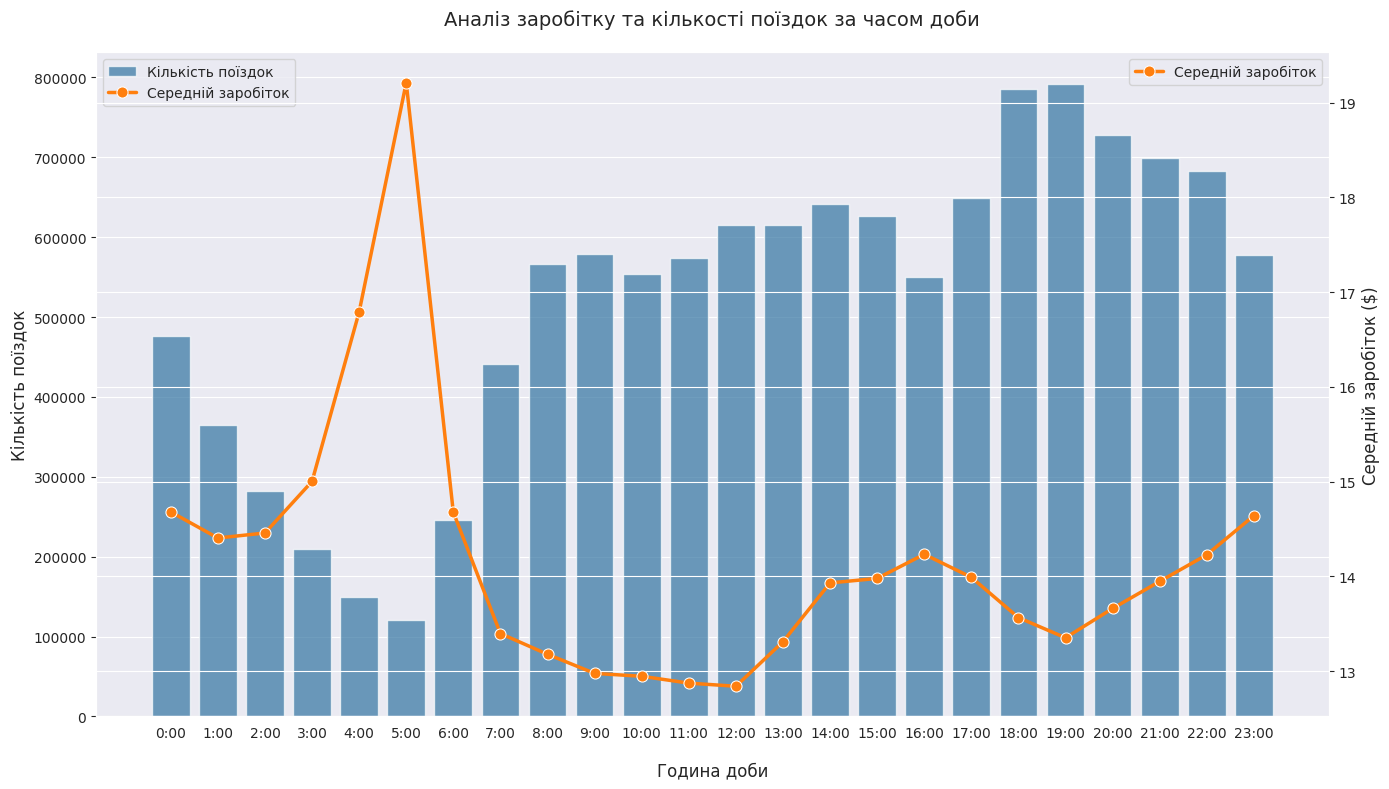

In [26]:
# 3. Візуалізація
plt.figure(figsize=(14, 8))
sns.set_style("darkgrid")  # Стиль з темною сіткою
sns.set_palette("viridis") # Сучасна палітра кольорів

# Створення графіка з двома осями
ax1 = sns.barplot(
    x="pickup_hour", 
    y="trips_count", 
    data=result_pd, 
    color="#1f77b4",  # Синій для кількості поїздок
    label="Кількість поїздок",
    alpha=0.7
)

ax2 = ax1.twinx()
sns.lineplot(
    x="pickup_hour", 
    y="avg_income", 
    data=result_pd, 
    color="#ff7f0e",   # Помаранчевий для заробітку
    marker="o", 
    linewidth=2.5,
    markersize=8,
    ax=ax2, 
    label="Середній заробіток"
)

# Налаштування підписів
ax1.set_xlabel("Година доби", fontsize=12, labelpad=15)
ax1.set_ylabel("Кількість поїздок", fontsize=12)
ax2.set_ylabel("Середній заробіток ($)", fontsize=12)
plt.title("Аналіз заробітку та кількості поїздок за часом доби", fontsize=14, pad=20)

# Легенда
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Форматування годин (додати AM/PM)
ax1.set_xticklabels([f"{h}:00" for h in range(24)])

plt.tight_layout()
plt.show()

# TRIP DISTANCE (Join, Filter, Group By)

In [27]:
joined_df = df_trip.join(
    df_fare,
    ["medallion", "hack_license","pickup_datetime","vendor_id"],
    "inner"
)

from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Визначення груп дистанції (0-3, 3-6, ..., 15-16 миль)
result = joined_df.filter(
    (F.col("payment_type") == "CRD") &  # Чаївні зазвичай записуються для CRD
    (F.col("trip_distance") >= 0) & 
    (F.col("trip_distance") <= 16)
).withColumn(
    "distance_group",
    F.floor(F.col("trip_distance") / 3) * 3
).groupBy("distance_group") \
.agg(
    F.avg("tip_amount").alias("avg_tip"),
    F.count("*").alias("trips_count")
).orderBy("distance_group")

# Конвертація у Pandas
result_pd = result.toPandas()


25/04/16 10:25:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:25:51 WARN RowBasedKeyValueBatch: Calling spill() on

/tmp/ipykernel_224394/1516915901.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font fam

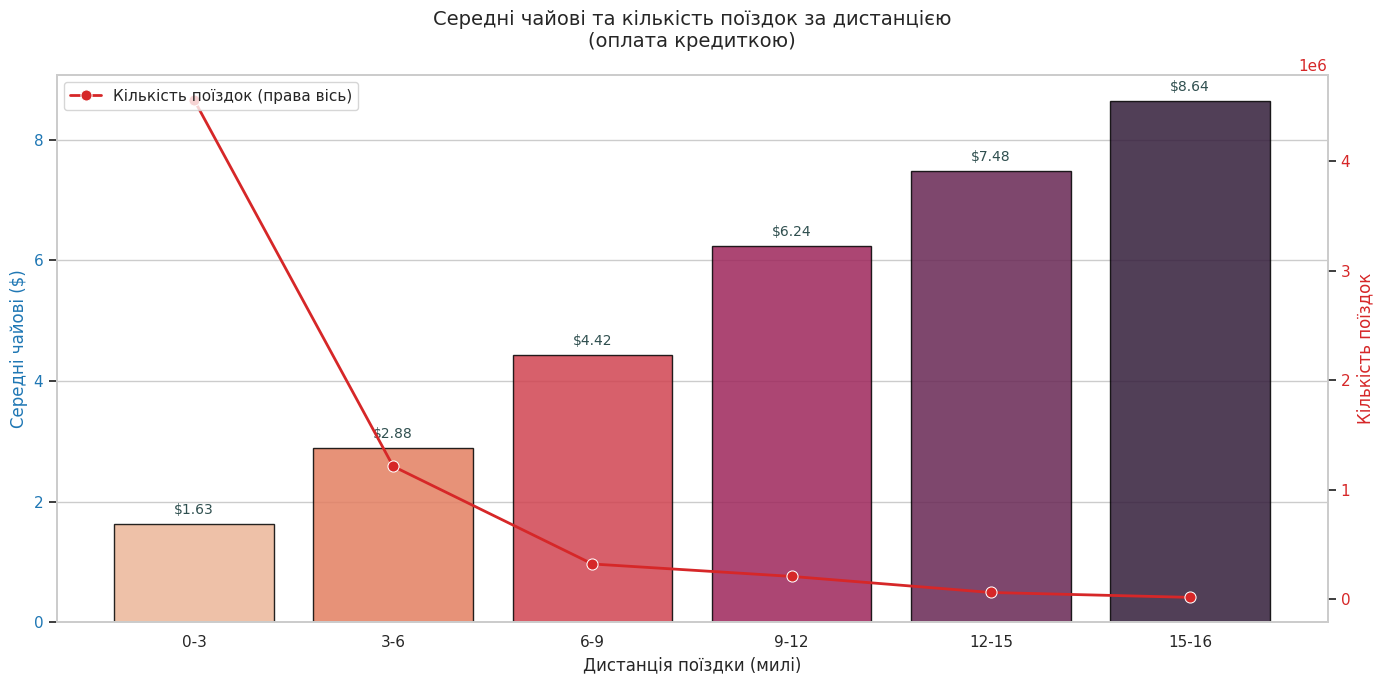

In [28]:
result_pd = result.toPandas()
result_pd["distance_group"] = result_pd["distance_group"].apply(
    lambda x: f"{x}-{x+3}" if x < 15 else "15-16"
)

plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid", font="Arial", palette="viridis")

custom_palette = sns.color_palette("rocket_r", n_colors=len(result_pd))
# Barplot (ліва вісь)
ax1 = sns.barplot(
    x="distance_group", 
    y="avg_tip", 
    data=result_pd, 
    palette=custom_palette,
    edgecolor="black",
    alpha=0.85,
    dodge=False,
    saturation=0.8,
    label="Середні чайові (ліва вісь)"
)

# Налаштування лівої осі
ax1.set_xlabel("Дистанція поїздки (милі)", fontsize=12)
ax1.set_ylabel("Середні чайові ($)", fontsize=12, color="#1f77b4")
ax1.tick_params(axis="y", labelcolor="#1f77b4")

# Додати значення на стовпці
for p in ax1.patches:
    ax1.annotate(
        f"${p.get_height():.2f}", 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        xytext=(0, 10), 
        textcoords='offset points',
        color="#2f4f4f",
        fontsize=10
    )

# Лінійний графік (права вісь)
ax2 = ax1.twinx()
sns.lineplot(
    x="distance_group", 
    y="trips_count", 
    data=result_pd, 
    color="#d62728", 
    marker="o",
    linewidth=2,
    markersize=8,
    ax=ax2,
    label="Кількість поїздок (права вісь)"
)

# Налаштування правої осі
ax2.set_ylabel("Кількість поїздок", fontsize=12, color="#d62728")
ax2.tick_params(axis="y", labelcolor="#d62728")
ax2.grid(False)  # Вимкнути сітку для правої осі

# Загальні налаштування
plt.title("Середні чайові та кількість поїздок за дистанцією\n(оплата кредиткою)", 
          fontsize=14, pad=20)
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc="upper left")

plt.tight_layout()
plt.show()

In [29]:
result.write.csv('../results/avg_tip_by_distance.csv')

25/04/16 10:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 10:26:33 WARN RowBasedKeyValueBatch: Calling spill() on

# Camulative by week


[995.458s][warning][gc,alloc] Executor task launch worker for task 23.0 in stage 193.0 (TID 830): Retried waiting for GCLocker too often allocating 1048578 words


25/04/16 10:28:12 WARN TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
25/04/16 10:28:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:28:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:28:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:28:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:28:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/16 10:28:46 WARN WindowExec: No Partition Defined for Window operation! M

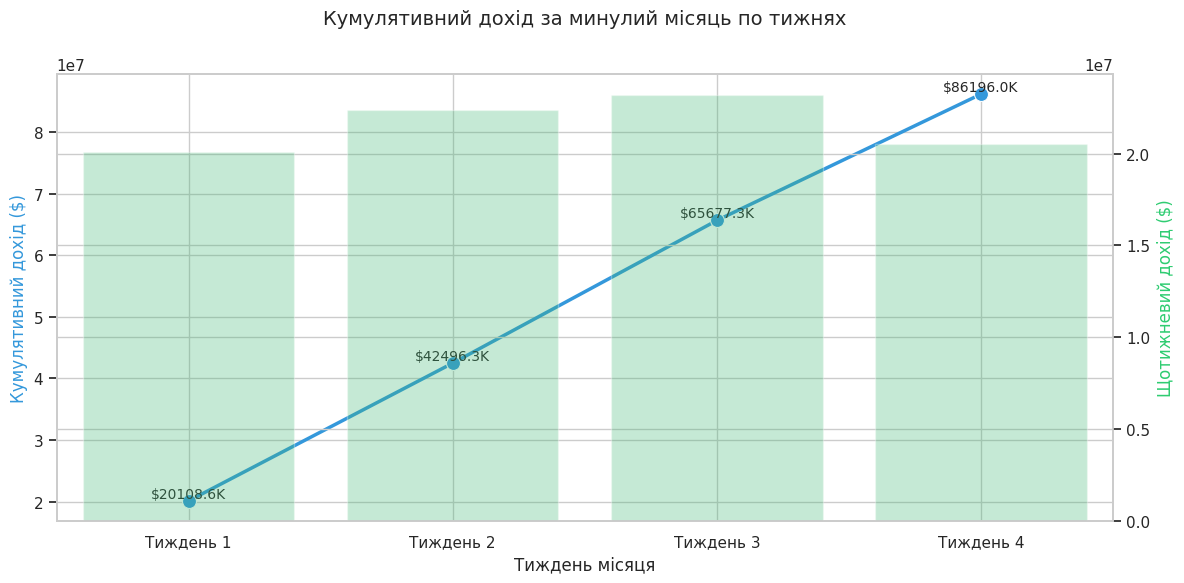

In [30]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt

joined_df = df_trip.join(
    df_fare,
    ["medallion", "hack_license", "pickup_datetime", "vendor_id"],
    "inner"
)

max_date = joined_df.agg(F.max(F.to_date("pickup_datetime"))).collect()[0][0]
# 1. Визначити початок і кінець минулого місяця
last_month_start = F.date_trunc('month', max_date - F.expr("INTERVAL 1 MONTH"))
last_month_end = F.last_day(last_month_start)
current_date = joined_df.agg(F.max(F.to_date("pickup_datetime"))).collect()[0][0]
start_date = F.date_sub(F.lit(current_date), 90)

# Фільтрація даних за останній тиждень
filtered_df = joined_df.filter(
    (F.col("pickup_datetime") >= start_date) & (F.col("vendor_id") == "CMT") &
    (F.col("pickup_datetime") < F.lit(current_date))
)
# 2. Відфільтрувати дані за минулий місяць
#filtered_df = joined_df.filter(
#    (F.col("pickup_datetime") >= last_month_start) & 
#    (F.col("pickup_datetime") <= last_month_end)
#)

# 3. Розрахувати тиждень місяця (1-5) та суму доходу
weekly_data = filtered_df.withColumn("day_of_month", F.dayofmonth("pickup_datetime")) \
    .withColumn("week_of_month", ((F.col("day_of_month") - 1) / 7).cast("int") + 1) \
    .groupBy("week_of_month") \
    .agg(F.sum("total_amount").alias("weekly_income")) \
    .orderBy("week_of_month")

# 4. Кумулятивний дохід за тижнями
window = Window.orderBy("week_of_month")
cumulative_df = weekly_data.withColumn("cumulative_income", F.sum("weekly_income").over(window))

# 5. Конвертація в Pandas
cumulative_pd = cumulative_df.toPandas()
cumulative_pd["week_label"] = cumulative_pd["week_of_month"].apply(lambda x: f"Тиждень {x}")

# 6. Візуалізація
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid", palette="pastel")

# Графік кумулятивного доходу
ax = sns.lineplot(
    x="week_label", 
    y="cumulative_income", 
    data=cumulative_pd, 
    marker="o", 
    linewidth=2.5,
    markersize=10,
    color="#3498db"
)

# Стовпці щотижневого доходу
ax2 = ax.twinx()
sns.barplot(
    x="week_label", 
    y="weekly_income", 
    data=cumulative_pd, 
    alpha=0.3,
    color="#2ecc71",
    ax=ax2
)

# Налаштування підписів
ax.set_xlabel("Тиждень місяця", fontsize=12)
ax.set_ylabel("Кумулятивний дохід ($)", fontsize=12, color="#3498db")
ax2.set_ylabel("Щотижневий дохід ($)", fontsize=12, color="#2ecc71")
plt.title("Кумулятивний дохід за минулий місяць по тижнях\n", fontsize=14, pad=20)

# Додати значення
for idx, row in cumulative_pd.iterrows():
    ax.text(
        idx, 
        row["cumulative_income"], 
        f"${row['cumulative_income']/1000:.1f}K", 
        ha='center', 
        va='bottom', 
        fontsize=10
    )

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [32]:
cumulative_pd.to_csv('../results/cumulative_by_week.csv')